In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_squared_log_error 

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Загружаем датасеты:

In [2]:
btc = pd.read_csv('coin_Bitcoin.csv')
binCoin = pd.read_csv('coin_BinanceCoin.csv')
doge = pd.read_csv('coin_Dogecoin.csv')
eth = pd.read_csv('coin_Ethereum.csv')
ltc = pd.read_csv('coin_Litecoin.csv')
tether = pd.read_csv('coin_Tether.csv')
tron = pd.read_csv('coin_Tron.csv')

Визуализация

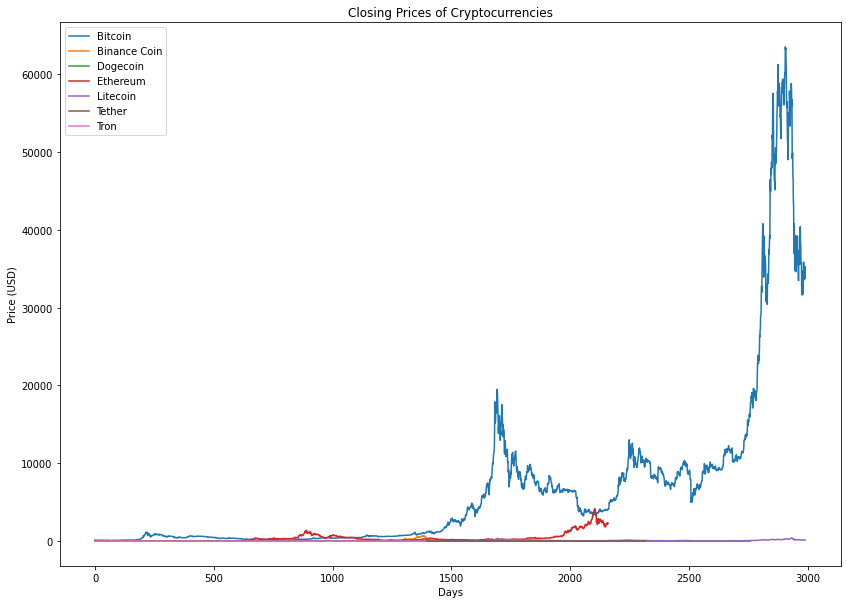

In [3]:
plt.figure(figsize=(14, 10))

plt.plot(btc['Close'])
plt.plot(binCoin['Close'])
plt.plot(doge['Close'])
plt.plot(eth['Close'])
plt.plot(ltc['Close'])
plt.plot(tether['Close'])
plt.plot(tron['Close'])

plt.legend(['Bitcoin', 'Binance Coin', 'Dogecoin', 'Ethereum', 'Litecoin', 'Tether', 'Tron'])
plt.title('Closing Prices of Cryptocurrencies')
plt.xlabel('Days')
plt.ylabel('Price (USD)')



plt.show()

Как видим, Биткоин имеют цену сильно выше, чем у всех остальных валют. Рассмотрим их отдельно.

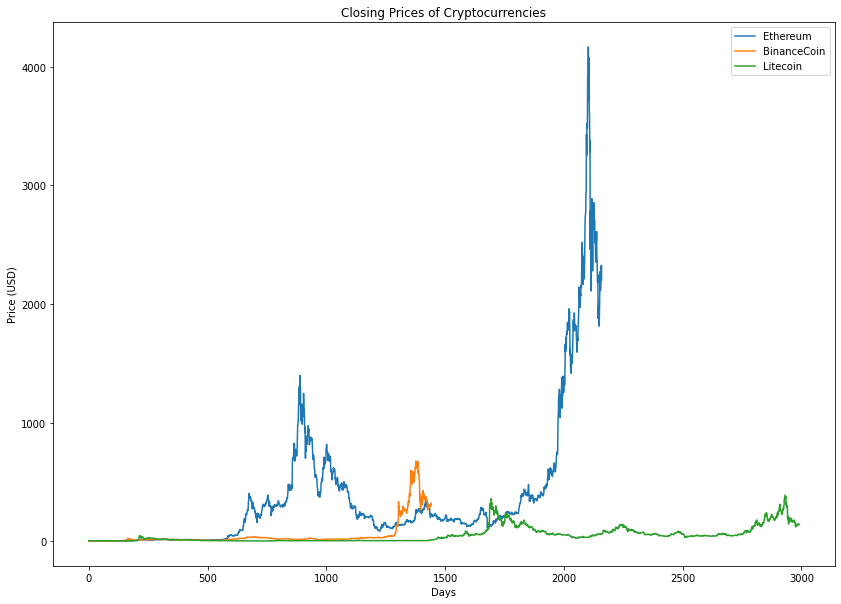

In [4]:
plt.figure(figsize=(14, 10))

plt.plot(eth['Close'])
plt.plot(binCoin['Close'])
plt.plot(ltc['Close'])


plt.legend(['Ethereum', 'BinanceCoin', 'Litecoin'])
plt.title('Closing Prices of Cryptocurrencies')
plt.xlabel('Days')
plt.ylabel('Price (USD)')


plt.show()

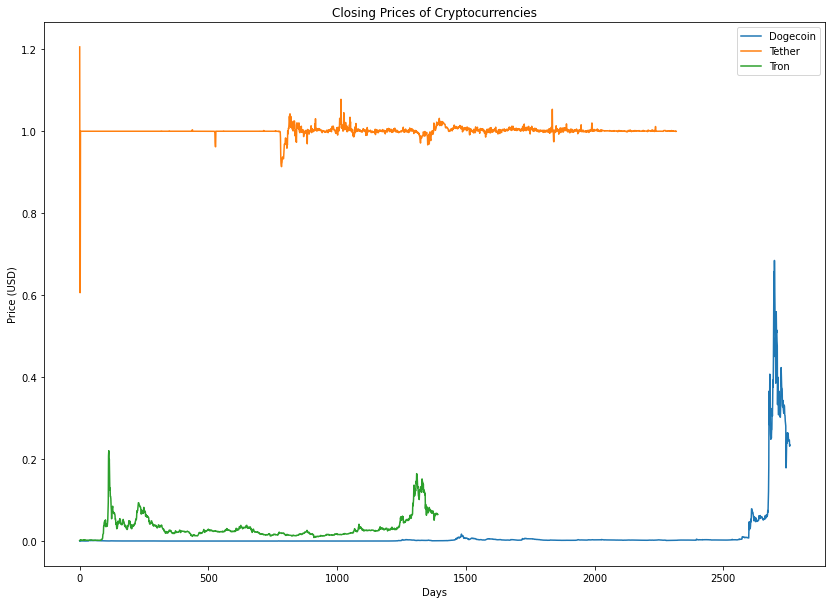

In [5]:
plt.figure(figsize=(14, 10))

plt.plot(doge['Close'])
plt.plot(tether['Close'])
plt.plot(tron['Close'])

plt.legend(['Dogecoin', 'Tether', 'Tron'])
plt.title('Closing Prices of Cryptocurrencies')
plt.xlabel('Days')
plt.ylabel('Price (USD)')


plt.show()

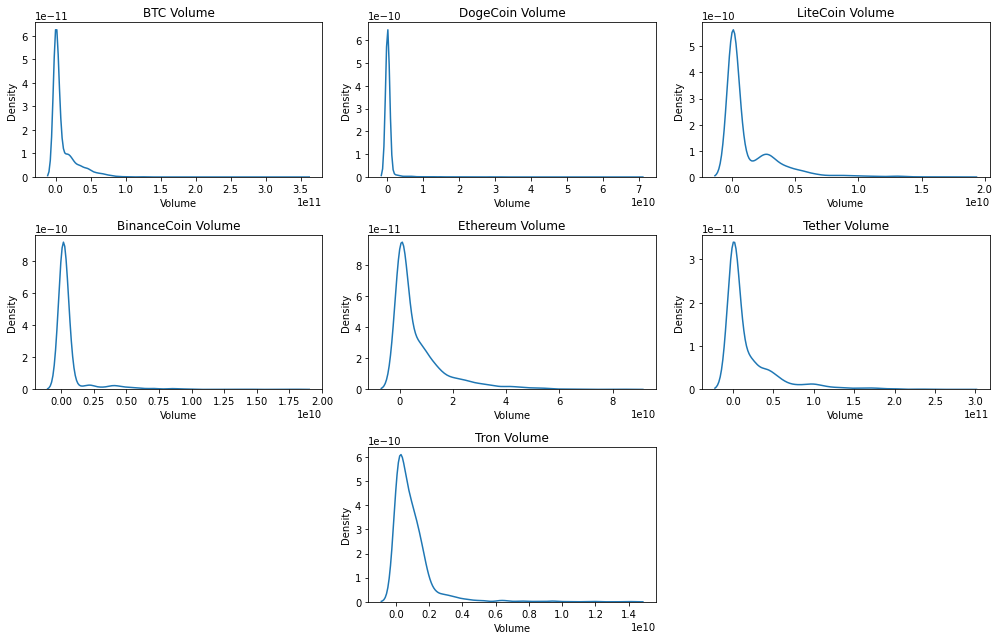

In [6]:
f, axs = plt.subplots(3, 3, figsize=(14, 9))
sns.kdeplot(btc['Volume'], ax=axs[0,0]).set_title('BTC Volume')
sns.kdeplot(doge['Volume'], ax=axs[0,1]).set_title('DogeCoin Volume')
sns.kdeplot(ltc['Volume'], ax=axs[0,2]).set_title('LiteCoin Volume')
sns.kdeplot(binCoin['Volume'], ax=axs[1,0]).set_title('BinanceCoin Volume')
sns.kdeplot(eth['Volume'], ax=axs[1,1]).set_title('Ethereum Volume')
sns.kdeplot(tether['Volume'], ax=axs[1,2]).set_title('Tether Volume')
sns.kdeplot(tron['Volume'], ax=axs[2,1]).set_title('Tron Volume')
f.delaxes(axs[2,0])
f.delaxes(axs[2,2])

f.tight_layout()

Препроцессинг

In [7]:
def dropper(df):
    df = df.drop(columns='SNo')
    return df

def printer(df):
    print(df['Symbol'][0])
    print(df.info())
    print('\n', '###############################################################################################################')
    print('\nОписательная статистика: \n', df.describe())
    print('\n','###############################################################################################################', '\n')
    print('Пропущенные значения: \n', df.isna().sum(),'\n')
    

def magic_describer(*dfs):
    for df in dfs:
        dropper(df)
        printer(df)
        
magic_describer(btc, binCoin, doge, eth, ltc, tether, tron)

BTC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 233.8+ KB
None

 ###############################################################################################################

Описательная статистика: 
                SNo          High           Low          Open         Close  \
count  2991.000000   2991.000000   2991.000000   2991.000000   2991.000000   
mean   1496.000000   6893.326038   6486.00

Пропущенные значения: 
 SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64 

TRX
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        1392 non-null   int64  
 1   Name       1392 non-null   object 
 2   Symbol     1392 non-null   object 
 3   Date       1392 non-null   object 
 4   High       1392 non-null   float64
 5   Low        1392 non-null   float64
 6   Open       1392 non-null   float64
 7   Close      1392 non-null   float64
 8   Volume     1392 non-null   float64
 9   Marketcap  1392 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 108.9+ KB
None

 ###############################################################################################################

Описательная статистика: 
          

Как видим, для нашего исследования количества информации в датасете избыточно. Судя по тому, как менялся marketcap - Биткоин всё сильнее забирает рынок. Видим, что значительную разницу между значениями между 2 и 3 квартилем, и огромную между 3-м квартилем и максимальным значением. Обычно такие выбросы очищаются, но, так как мы работаем с криптовалютой (логика та же, что и с акциями), то удалять такие значения не имеет смысла, нам важно видеть все скачки цены. С типами проблем нет. Пропущенных значений нет.

Работа с моделью

<ipython-input-8-729c971db04f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(dropper(btc).corr(), fignum=f.number)


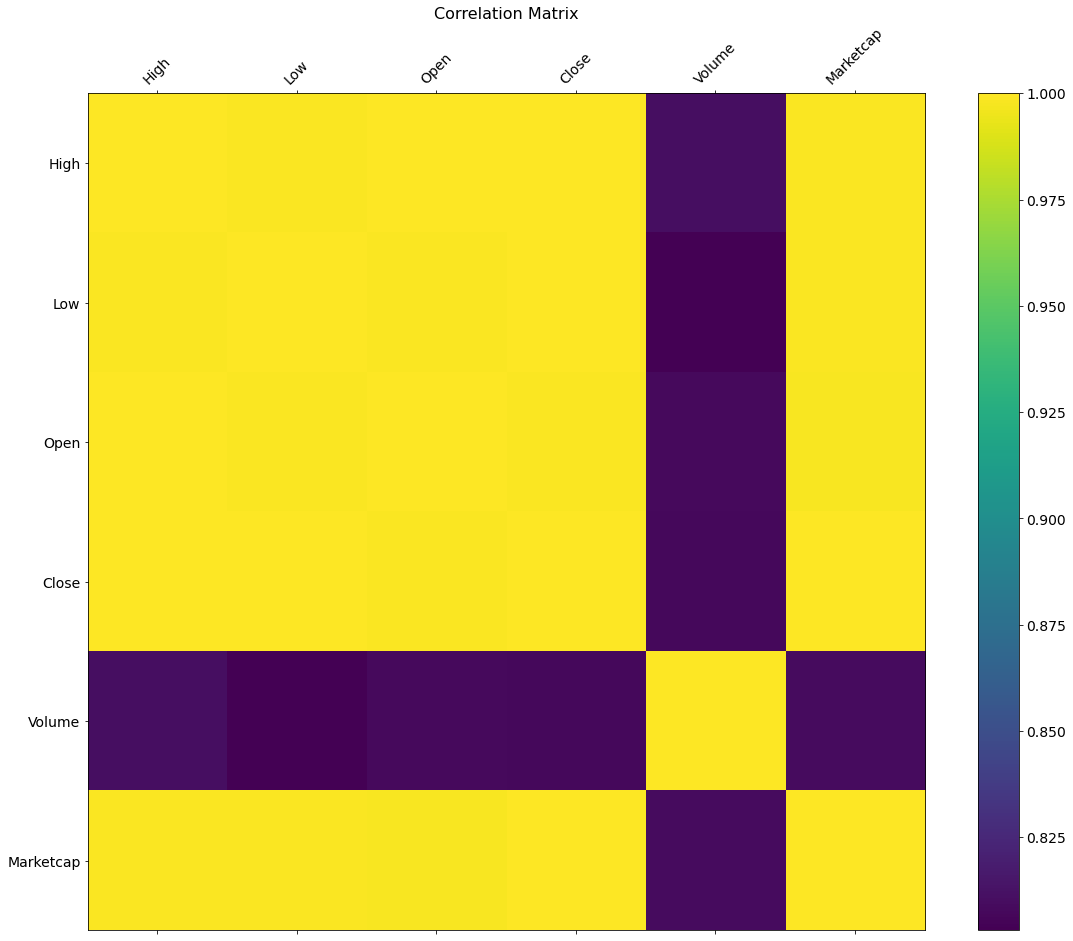

In [8]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dropper(btc).corr(), fignum=f.number)
plt.xticks(range(dropper(btc).select_dtypes(['number']).shape[1]), dropper(btc).select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dropper(btc).select_dtypes(['number']).shape[1]), dropper(btc).select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Видим насколько зависят друг от друга столбцы датасета. Строим матрицу корелляции только для одной валюты, так как смысл от этого не поменяется. Полезной информации для нас здесь почти нет. Мы будем пользоваться только столбцами "Дата" и "Цена закрытия".

Чтобы нам проще было работать с таким количеством датафреймов, напишем функция для препроцессинга данных.

In [9]:
def preprocess_and_train(df, model, res):
    close_prices = df['Close'].values.reshape(-1, 1)

    # Нормализуем данные
    scaler = MinMaxScaler()
    close_prices = scaler.fit_transform(close_prices)

    df = df.drop(columns=['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Volume', 'Marketcap'])

    # Создаем входные и выходные последовательности
    x = []
    y = []
    for i in range(len(close_prices) - seq_length - 1):
        _x = close_prices[i:(i+seq_length)]
        _y = close_prices[i+seq_length]
        x.append(_x)
        y.append(_y)
    x = np.array(x)
    y = np.array(y)

    # Разбиваем данные на тренировочную и тестовую выборки
    train_size = int(len(x) * 0.7)
    test_size = len(x) - train_size
    train_x, test_x = torch.from_numpy(x[0:train_size,:,:]).type(torch.Tensor), torch.from_numpy(x[train_size:len(x),:,:]).type(torch.Tensor)
    train_y, test_y = torch.from_numpy(y[0:train_size,:]).type(torch.Tensor), torch.from_numpy(y[train_size:len(y),:]).type(torch.Tensor)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=res)

    for epoch in range(700):
        optimizer.zero_grad()
        outputs = model(train_x.to(device))
        loss = criterion(outputs, train_y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            if epoch<100: 
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            else: 
                if epoch % 50 == 0: 
                    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    # Предсказываем значения на тестовой выборке
    model.eval()
    test_predict = model(test_x.to(device))
    
    # Вычисляем ошибку на тестовой выборке
    test_loss = criterion(test_predict, test_y.to(device))

    # Визуализируем результаты
    test_predict = test_predict.cpu().detach().numpy()
    test_y = test_y.cpu().detach().numpy()

    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(test_y)
    print('R^2 score:', r2_score(test_y, test_predict))
    print('mean_absolute_error', mean_absolute_error(test_y, test_predict))
    print('root mean squared error: ', mean_squared_error(test_y, test_predict, squared=False))
    print('root mean squared logarithmic error: ', mean_squared_log_error(test_y, test_predict, squared=False))
    print('median_absolute_error', median_absolute_error(test_y, test_predict))
    plt.plot(test_y, label='Истинные значения')
    plt.plot(test_predict, label='Предсказанные значения')
    plt.xlabel('День')
    plt.ylabel('Цена закрытия')
    plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке с использование модели: {:.4f}'.format(test_loss))
    plt.legend()
    plt.show()

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, h_n = self.rnn(x, h0)

        out = self.fc(out[:, -1, :])

        return out

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (h_n, c_n) = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, h_n = self.gru(x, h0)

        out = self.fc(out[:, -1, :])

        return out

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Задаем гиперпараметры модели
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 1
seq_length = 30 # длина входной последовательности (количество дней для предсказания)

Epoch: 0, loss: 0.01945
Epoch: 10, loss: 0.00683
Epoch: 20, loss: 0.04985
Epoch: 30, loss: 0.00416
Epoch: 40, loss: 0.00934
Epoch: 50, loss: 0.00369
Epoch: 60, loss: 0.00321
Epoch: 70, loss: 0.00326
Epoch: 80, loss: 0.00302
Epoch: 90, loss: 0.00293
Epoch: 100, loss: 0.00290
Epoch: 150, loss: 0.00285
Epoch: 200, loss: 0.00243
Epoch: 250, loss: 0.00027
Epoch: 300, loss: 0.00010
Epoch: 350, loss: 0.00006
Epoch: 400, loss: 0.00022
Epoch: 450, loss: 0.00005
Epoch: 500, loss: 0.00004
Epoch: 550, loss: 0.00003
Epoch: 600, loss: 0.00016
Epoch: 650, loss: 0.00004
R^2 score: 0.410997791162818
mean_absolute_error 5639.01
root mean squared error:  12117.355
root mean squared logarithmic error:  0.36297774
median_absolute_error 453.95215


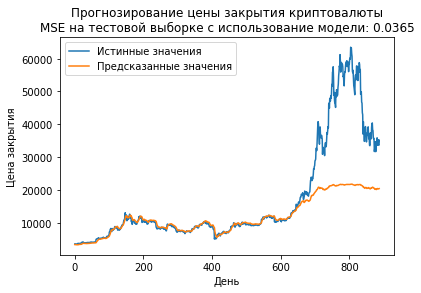

Wall time: 1min 22s


In [17]:
%%time
dl_model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(btc, dl_model, 0.015)

Epoch: 0, loss: 0.01166
Epoch: 10, loss: 0.00315
Epoch: 20, loss: 0.00279
Epoch: 30, loss: 0.00189
Epoch: 40, loss: 0.00023
Epoch: 50, loss: 0.00012
Epoch: 60, loss: 0.00006
Epoch: 70, loss: 0.00005
Epoch: 80, loss: 0.00004
Epoch: 90, loss: 0.00004
Epoch: 100, loss: 0.00004
Epoch: 150, loss: 0.00003
Epoch: 200, loss: 0.00003
Epoch: 250, loss: 0.00002
Epoch: 300, loss: 0.00002
Epoch: 350, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 450, loss: 0.00007
Epoch: 500, loss: 0.00002
Epoch: 550, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 650, loss: 0.00001
R^2 score: 0.9303337882323979
mean_absolute_error 1870.0854
root mean squared error:  4167.355
root mean squared logarithmic error:  0.09629927
median_absolute_error 205.50708


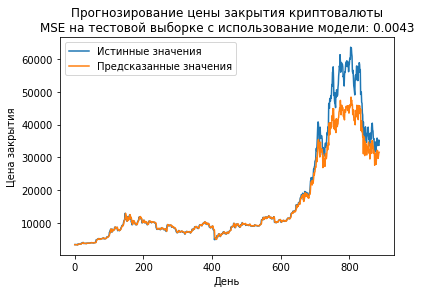

Wall time: 2min 2s


In [18]:
%%time
dl_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(btc, dl_model, 0.015)

Epoch: 0, loss: 0.00276
Epoch: 10, loss: 0.00486
Epoch: 20, loss: 0.00361
Epoch: 30, loss: 0.00220
Epoch: 40, loss: 0.00183
Epoch: 50, loss: 0.00098
Epoch: 60, loss: 0.00008
Epoch: 70, loss: 0.00007
Epoch: 80, loss: 0.00005
Epoch: 90, loss: 0.00002
Epoch: 100, loss: 0.00002
Epoch: 150, loss: 0.00002
Epoch: 200, loss: 0.00002
Epoch: 250, loss: 0.00002
Epoch: 300, loss: 0.00002
Epoch: 350, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 450, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 550, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 650, loss: 0.00001
R^2 score: 0.9473983622068325
mean_absolute_error 1615.2677
root mean squared error:  3621.171
root mean squared logarithmic error:  0.08322416
median_absolute_error 204.33325


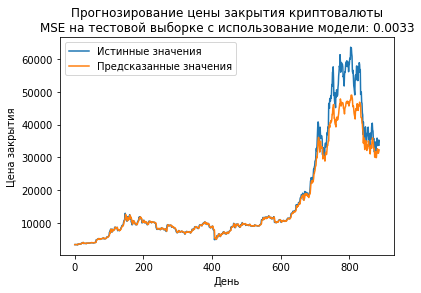

Wall time: 2min 56s


In [19]:
%%time
dl_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(btc, dl_model, 0.015)

GRU по всем метрикам оказалась лучше. Теперь подберем под неё гиперпараметр, чтобы она показывала наилучшие результаты и предскажем стоимость по всем остальным криптовалютам. Для этого делаем обёрточный класс, чтобы можно было использовать GridSearchCV

In [27]:
from sklearn.base import BaseEstimator, RegressorMixin
class GRUWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1, learning_rate=0.001):
        self.model = GRU(input_size, hidden_size, num_layers, output_size)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def fit(self, X, y):
        X = X.to(device)
        y = y.to(device)
        self.model.train()
        for epoch in range(100):
            self.optimizer.zero_grad()
            output = self.model(X)
            loss = self.loss_fn(output, y)
            loss.backward()
            self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X = X.to(device)
            output = self.model(X)
            return output.cpu().numpy()

    def score(self, X, y):
        X = X.to(device)
        y = y.to(device)
        output = self.predict(X)
        loss = self.loss_fn(torch.Tensor(output), y)
        return -loss.item()

    def get_params(self, deep=True):
        return {'input_size': self.model.gru.input_size,
                'hidden_size': self.model.gru.hidden_size,
                'num_layers': self.model.gru.num_layers,
                'output_size': self.model.fc.out_features,
                'learning_rate': self.optimizer.param_groups[0]['lr']}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return self


In [28]:
def preprocess_and_train_with_grid(df, model, res):
    close_prices = df['Close'].values.reshape(-1, 1)

    # Нормализуем данные
    scaler = MinMaxScaler()
    close_prices = scaler.fit_transform(close_prices)

    df = df.drop(columns=['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Volume', 'Marketcap'])

    # Создаем входные и выходные последовательности
    x = []
    y = []
    for i in range(len(close_prices) - seq_length - 1):
        _x = close_prices[i:(i+seq_length)]
        _y = close_prices[i+seq_length]
        x.append(_x)
        y.append(_y)
    x = np.array(x)
    y = np.array(y)

    # Разбиваем данные на тренировочную и тестовую выборки
    train_size = int(len(x) * 0.7)
    test_size = len(x) - train_size
    train_x, test_x = torch.from_numpy(x[0:train_size,:,:]).type(torch.Tensor), torch.from_numpy(x[train_size:len(x),:,:]).type(torch.Tensor)
    train_y, test_y = torch.from_numpy(y[0:train_size,:]).type(torch.Tensor), torch.from_numpy(y[train_size:len(y),:]).type(torch.Tensor)
    
    params = {'learning_rate': [0.001, 0.01, 0.1, 0.011,0.013, 0.015, 0.017, 0.02, 0.03]}

    grid_search = GridSearchCV(estimator=GRUWrapper(input_size, hidden_size, num_layers, output_size), param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(train_x, train_y)
    res = grid_search.best_params_['learning_rate']
    print('Лучшее значение скорости обучения: ', res)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=res)

    
    for epoch in range(700):
        optimizer.zero_grad()
        outputs = model(train_x.to(device))
        loss = criterion(outputs, train_y.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            if epoch<100: 
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            else: 
                if epoch % 50 == 0: 
                    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    # Предсказываем значения на тестовой выборке
    model.eval()
    test_predict = model(test_x.to(device))
    
    # Вычисляем ошибку на тестовой выборке
    test_loss = criterion(test_predict, test_y.to(device))

    # Визуализируем результаты
    test_predict = test_predict.cpu().detach().numpy()
    test_y = test_y.cpu().detach().numpy()

    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(test_y)
    print('R^2 score:', r2_score(test_y, test_predict))
    print('mean_absolute_error', mean_absolute_error(test_y, test_predict))
    print('root mean squared error: ', mean_squared_error(test_y, test_predict, squared=False))
    print('root mean squared logarithmic error: ', mean_squared_log_error(test_y, test_predict, squared=False))
    print('median_absolute_error', median_absolute_error(test_y, test_predict))
    plt.plot(test_y, label='Истинные значения')
    plt.plot(test_predict, label='Предсказанные значения')
    plt.xlabel('День')
    plt.ylabel('Цена закрытия')
    plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке с использование модели: {:.4f}'.format(test_loss))
    plt.legend()
    plt.show()

Лучшее значение скорости обучения:  0.03
Epoch: 0, loss: 0.01173
Epoch: 10, loss: 0.00736
Epoch: 20, loss: 0.00390
Epoch: 30, loss: 0.00185
Epoch: 40, loss: 0.00067
Epoch: 50, loss: 0.00026
Epoch: 60, loss: 0.00005
Epoch: 70, loss: 0.00005
Epoch: 80, loss: 0.00003
Epoch: 90, loss: 0.00003
Epoch: 100, loss: 0.00003
Epoch: 150, loss: 0.00002
Epoch: 200, loss: 0.00002
Epoch: 250, loss: 0.00002
Epoch: 300, loss: 0.00002
Epoch: 350, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 450, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 550, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 650, loss: 0.00002
R^2 score: 0.8995240567563872
mean_absolute_error 107.90085
root mean squared error:  286.41626
root mean squared logarithmic error:  0.12972178
median_absolute_error 8.944244


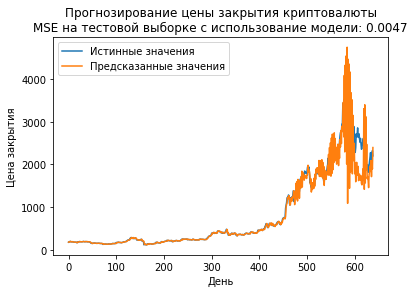

Wall time: 8min 4s


In [29]:
%%time
dl_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train_with_grid(eth, dl_model, 0.015)

Epoch: 0, loss: 0.02118
Epoch: 10, loss: 0.00020
Epoch: 20, loss: 0.00232
Epoch: 30, loss: 0.00094
Epoch: 40, loss: 0.00021
Epoch: 50, loss: 0.00019
Epoch: 60, loss: 0.00015
Epoch: 70, loss: 0.00014
Epoch: 80, loss: 0.00013
Epoch: 90, loss: 0.00012
Epoch: 100, loss: 0.00012
Epoch: 150, loss: 0.00010
Epoch: 200, loss: 0.00005
Epoch: 250, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 350, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 450, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 550, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 650, loss: 0.00000
R^2 score: 0.9498706200737542
mean_absolute_error 16.790554
root mean squared error:  40.600117
root mean squared logarithmic error:  0.099958956
median_absolute_error 1.0626917


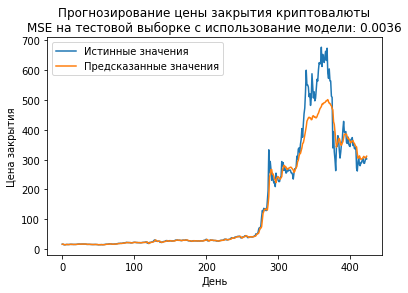

Wall time: 1min 53s


In [30]:
%%time
dl_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(binCoin, dl_model, 0.03)

Epoch: 0, loss: 0.01170
Epoch: 10, loss: 0.00001
Epoch: 20, loss: 0.00001
Epoch: 30, loss: 0.00002
Epoch: 40, loss: 0.00001
Epoch: 50, loss: 0.00001
Epoch: 60, loss: 0.00001
Epoch: 70, loss: 0.00001
Epoch: 80, loss: 0.00001
Epoch: 90, loss: 0.00001
Epoch: 100, loss: 0.00001
Epoch: 150, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 250, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 350, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 450, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 550, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 650, loss: 0.00000
R^2 score: 0.9006347055564652
mean_absolute_error 0.01015654
root mean squared error:  0.034400355
root mean squared logarithmic error:  0.02545268
median_absolute_error 7.354957e-05


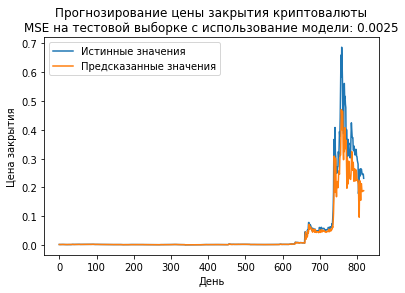

Wall time: 2min 46s


In [31]:
%%time
dl_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(doge, dl_model, 0.03)

Epoch: 0, loss: 0.02107
Epoch: 10, loss: 0.02071
Epoch: 20, loss: 0.00200
Epoch: 30, loss: 0.00185
Epoch: 40, loss: 0.00081
Epoch: 50, loss: 0.00043
Epoch: 60, loss: 0.00026
Epoch: 70, loss: 0.00019
Epoch: 80, loss: 0.00017
Epoch: 90, loss: 0.00016
Epoch: 100, loss: 0.00016
Epoch: 150, loss: 0.00016
Epoch: 200, loss: 0.00016
Epoch: 250, loss: 0.00013
Epoch: 300, loss: 0.00013
Epoch: 350, loss: 0.00012
Epoch: 400, loss: 0.00011
Epoch: 450, loss: 0.00010
Epoch: 500, loss: 0.00009
Epoch: 550, loss: 0.00010
Epoch: 600, loss: 0.00008
Epoch: 650, loss: 0.00007
R^2 score: 0.963238171415777
mean_absolute_error 5.762555
root mean squared error:  12.257263
root mean squared logarithmic error:  0.075447075
median_absolute_error 2.1280365


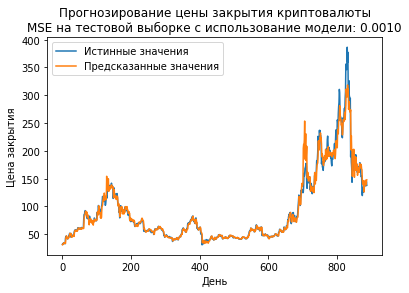

Wall time: 2min 43s


In [32]:
%%time
dl_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(ltc, dl_model, 0.03)

Epoch: 0, loss: 0.57361
Epoch: 10, loss: 0.01574
Epoch: 20, loss: 0.00044
Epoch: 30, loss: 0.00047
Epoch: 40, loss: 0.00063
Epoch: 50, loss: 0.00042
Epoch: 60, loss: 0.00023
Epoch: 70, loss: 0.00025
Epoch: 80, loss: 0.00023
Epoch: 90, loss: 0.00022
Epoch: 100, loss: 0.00022
Epoch: 150, loss: 0.00020
Epoch: 200, loss: 0.00018
Epoch: 250, loss: 0.00014
Epoch: 300, loss: 0.00012
Epoch: 350, loss: 0.00017
Epoch: 400, loss: 0.00012
Epoch: 450, loss: 0.00009
Epoch: 500, loss: 0.00018
Epoch: 550, loss: 0.00017
Epoch: 600, loss: 0.00014
Epoch: 650, loss: 0.00011
R^2 score: -0.6023955366476108
mean_absolute_error 0.0034887365
root mean squared error:  0.0048108096
root mean squared logarithmic error:  0.0023977743
median_absolute_error 0.0027607083


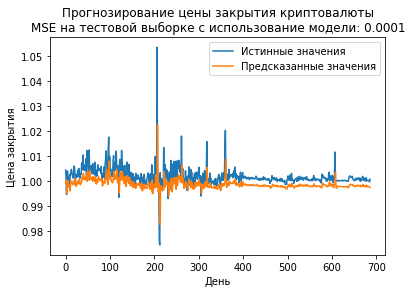

Wall time: 2min 14s


In [33]:
%%time
dl_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
preprocess_and_train(tether, dl_model, 0.03)